<a href="https://colab.research.google.com/github/dmw1998/Case_Study_Log/blob/main/Simple_OCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple Test Function

We would like to simulate the following system with CasADi. This an example similar to reference [1].

$$
\begin{aligned}
\dot{h} &= V \sin \gamma + W_{h} \\
\dot{x} &= V \cos \gamma \\
m\dot{V} &= T - D(V) - mg \sin \gamma - m\dot{W_h} \sin \gamma \\
mV\dot{\gamma} &= L(V) - mg \cos \gamma - m\dot{W_h} \cos \gamma
\end{aligned}
$$

In [ ]:
# !pip install casadi
import casadi as ca

# Define parameters
m = ca.MX.sym('m')      # mass
g = ca.MX.sym('g')      # gravity

# Define states
h = ca.MX.sym('h')       # altitude
x = ca.MX.sym('x')       # horizontal position
V = ca.MX.sym('V')       # speed
gamma = ca.MX.sym('gamma')  # flight path angle

states = ca.vertcat(h, x, V, gamma)
n_states = states.size1()

# Define control input
T = ca.MX.sym('T')       # thrust
controls = ca.vertcat(T)
n_controls = controls.size1()

# Define wind and its derivative as time-dependent inputs (symbolic)
W_h = ca.MX.sym('W_h')         # vertical wind
dW_h = ca.MX.sym('dW_h')       # time derivative of W_h

# Define aerodynamic models
# e.g., Drag = c_D * V^2, Lift = c_L * V^2
c_D = ca.MX.sym('c_D')
c_L = ca.MX.sym('c_L')

D = c_D * V**2
L = c_L * V**2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 7.3 MB/s eta 0:00:00


In [ ]:
# Differential equations
dh_dt     = V * ca.sin(gamma) + W_h
dx_dt     = V * ca.cos(gamma)
dV_dt     = (T - D - m*g*ca.sin(gamma) - m*dW_h*ca.sin(gamma)) / m
dgamma_dt = (L - m*g*ca.cos(gamma) - m*dW_h*ca.cos(gamma)) / (m * V)

rhs = ca.vertcat(dh_dt, dx_dt, dV_dt, dgamma_dt)

In [ ]:
# All symbolic inputs
params = ca.vertcat(m, g, c_D, c_L)
wind = ca.vertcat(W_h, dW_h)

ode_function = ca.Function(
    'f_ode',
    [states, controls, wind, params],
    [rhs],
    ['x', 'u', 'w', 'p'],
    ['xdot']
)

Our windshear model follows the *Wind model 1 from Optimal Abort Landing in the Presence of Severe Windshears*.

$$ W_h =
\begin{cases}
0, && x \leq a, \\
-k(h/h_{*}) \frac{(x-a)}{(c-b)}, && a \leq x \leq c, \\
-k(h/h_{*}) \frac{(b-x)}{(b-c)}, && c \leq x \leq b, \\
0, && x \geq b.
\end{cases}
$$

In [ ]:
# Symbols
k = ca.MX.sym('k')       # wind strength
a = ca.MX.sym('a')
b = ca.MX.sym('b')
c = ca.MX.sym('c')
h_star = ca.MX.sym('h_star')

# Piecewise definition of W_h
Wh_expr = ca.if_else(x <= a, 0,
             ca.if_else(x <= c, -k * (h / h_star) * (x - a) / (c - a),
             ca.if_else(x <= b, -k * (h / h_star) * (b - x) / (b - c),
             0)))

Wh_fun = ca.Function('Wh', [x, h, k, a, b, c, h_star], [Wh_expr])

Find $\dot{W_{h}}$ in CasADi.

In [ ]:
# Partial derivatives
dWh_dx = ca.gradient(Wh_expr, x)
dWh_dh = ca.gradient(Wh_expr, h)

# Time derivatives of x and h (from dynamics)
x_dot = V * ca.cos(gamma)
h_dot = V * ca.sin(gamma) + Wh_expr

# Compute dWh/dt
dWh_dt_expr = dWh_dx * x_dot + dWh_dh * h_dot
dWh_fun = ca.Function('dWh_dt', [x, h, V, gamma, k, a, b, c, h_star], [dWh_dt_expr])

## OCP without uncertainty

In [ ]:
# !pip install casadi
import casadi as ca
import numpy as np

# === SYMBOLIC DEFINITIONS ===
# States
h = ca.SX.sym('h')
x = ca.SX.sym('x')
V = ca.SX.sym('V')
gamma = ca.SX.sym('gamma')
states = ca.vertcat(h, x, V, gamma)

# Controls
T = ca.SX.sym('T')
controls = ca.vertcat(T)

# Parameters
m = ca.SX.sym('m')
g = ca.SX.sym('g')
c_D = ca.SX.sym('c_D')
c_L = ca.SX.sym('c_L')
params = ca.vertcat(m, g, c_D, c_L)

# Wind model parameters
k = ca.SX.sym('k')
a = ca.SX.sym('a')
b = ca.SX.sym('b')
c = ca.SX.sym('c')
h_star = ca.SX.sym('h_star')
wind_params = ca.vertcat(k, a, b, c, h_star)

# === WIND MODEL: W_h(x, h) and dW_h/dt ===

# Wind expression
Wh_expr = ca.if_else(x <= a, 0,
             ca.if_else(x <= c, -k * (h / h_star) * (x - a) / (c - a),
             ca.if_else(x <= b, -k * (h / h_star) * (b - x) / (b - c),
             0)))

# Partial derivatives
dWh_dx = ca.gradient(Wh_expr, x)
dWh_dh = ca.gradient(Wh_expr, h)

# Time derivatives of x and h
x_dot = V * ca.cos(gamma)
h_dot = V * ca.sin(gamma) + Wh_expr

# Total time derivative of W_h
dWh_dt_expr = dWh_dx * x_dot + dWh_dh * h_dot

# === AERODYNAMICS ===
D = c_D * V**2
L = c_L * V**2

# === DYNAMICS ===
dh_dt     = h_dot
dx_dt     = x_dot
dV_dt     = (T - D - m * g * ca.sin(gamma) - m * dWh_dt_expr * ca.sin(gamma)) / m
dgamma_dt = (L - m * g * ca.cos(gamma) - m * dWh_dt_expr * ca.cos(gamma)) / (m * V)

rhs = ca.vertcat(dh_dt, dx_dt, dV_dt, dgamma_dt)

# === FINAL FUNCTION ===
all_params = ca.vertcat(params, wind_params)
f_ode = ca.Function('f_ode',
                    [states, controls, all_params],
                    [rhs],
                    ['x', 'u', 'p'],
                    ['xdot'])


In [ ]:
# Define numerical values
x0 = np.array([1820.88, 0.0, 73.05, np.deg2rad(-2.249)])     # initial state: [h, x, V, gamma]
u0 = np.array([160000.0])                # thrust
p_val = np.array([67430.0, 9.81, 0.02, 0.04,   # m, g, c_D, c_L
                  1.0, 1524.0, 4572.0, 2743.2, 304.8]) # k, a, b, c, h_star

# Evaluate dynamics
xdot = f_ode(x=x0, u=u0, p=p_val)['xdot']
print("xdot =", xdot)

xdot = [-2.86666, 72.9937, 2.75622, -0.134145]


In [ ]:
# Time step
dt = 0.1  # integration time step, in seconds

# Define symbolic variables again
X = ca.SX.sym('X', 4)  # state: h, x, V, gamma
U = ca.SX.sym('U', 1)  # thrust
P = ca.SX.sym('P', 9)  # parameters: m, g, c_D, c_L, k, a, b, c, h_star

# Define DAE system
ode_rhs = f_ode(X, U, P)

dae = {'x': X, 'p': ca.vertcat(U, P), 'ode': ode_rhs}

# Create integrator
intg = ca.integrator('intg', 'cvodes', dae, {'tf': dt})

In [ ]:
# Concatenate control + parameters
param_val = np.concatenate((u0, p_val))

# Integrate
res = intg(x0=x0, p=param_val)
x1 = res['xf']
print("Next state after dt =", x1)

Next state after dt = [1820.54, 7.31122, 73.3322, -0.0526373]


In [ ]:
N_steps = 180
x_hist = [x0]
x_curr = x0.copy()

for _ in range(N_steps):
    res = intg(x0=x_curr, p=param_val)
    x_curr = res['xf'].full().flatten()
    x_hist.append(x_curr)

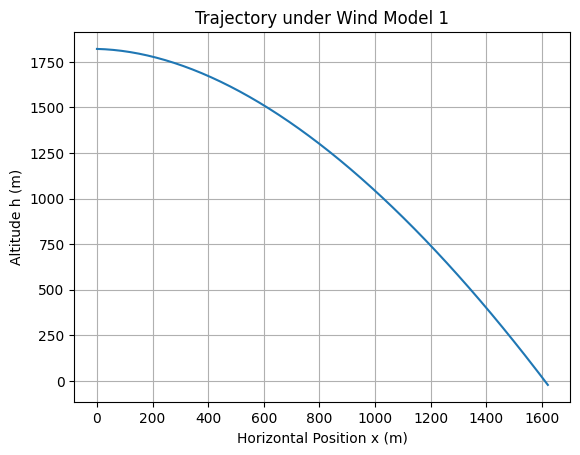

In [ ]:
import matplotlib.pyplot as plt
x_hist = np.array(x_hist)
plt.plot(x_hist[:,1], x_hist[:,0])  # x vs h
plt.xlabel("Horizontal Position x (m)")
plt.ylabel("Altitude h (m)")
plt.title("Trajectory under Wind Model 1")
plt.grid()
plt.show()

In [ ]:
# Define numerical values
x0 = np.array([1820.88, 0.0, 200.0, 0.1])     # initial state: [h, x, V, gamma]
u0 = np.array([10000.0])                # thrust
p_val = np.array([67430.0, 9.81, 0.02, 0.04,   # m, g, c_D, c_L
                  1.0, 1524.0, 4572.0, 2743.2, 304.8]) # k, a, b, c, h_star

# Evaluate dynamics
xdot = f_ode(x=x0, u=u0, p=p_val)['xdot']
print("xdot =", xdot)

xdot = [19.9667, 199.001, -0.842928, -0.0486863]


In [ ]:
def build_and_solve_ocp_with_integrator(f_ode, x0, p_val, T_min=0.0, T_max=200000.0, t_horizon=40.0, N=10):
    """
    Build and solve an optimal control problem using CasADi integrator (cvodes)
    instead of explicit Euler integration.

    Parameters:
    - f_ode: CasADi Function defining the system dynamics f(x, u, p) -> dx/dt
    - x0: Initial state, np.array of shape (4,)
    - p_val: Fixed parameter vector (e.g., [m, g, c_D, c_L, k, a, b, c, h_star])
    - T_min, T_max: Thrust bounds
    - t_horizon: Total time horizon
    - N: Number of discretization steps

    Returns:
    - opti: CasADi Opti instance
    - sol: Solver result
    - x_opt, u_opt: Optimal state and control trajectories
    """
    dt = t_horizon / N
    opti = ca.Opti()

    # Decision variables
    X = opti.variable(4, N+1)  # States: [h, x, V, gamma]
    U = opti.variable(1, N)    # Control: thrust

    # Initial condition
    opti.subject_to(X[:, 0] == x0)

    # Build integrator once (reuse inside loop)
    X_sym = ca.MX.sym('X', 4)
    U_sym = ca.MX.sym('U', 1)
    P_sym = ca.MX.sym('P', len(p_val))
    rhs = f_ode(X_sym, U_sym, P_sym)

    dae = {'x': X_sym, 'p': ca.vertcat(U_sym, P_sym), 'ode': rhs}
    intg = ca.integrator('intg', 'cvodes', dae, {'tf': dt})

    # Dynamics constraints using integrator
    for i in range(N):
        xi = X[:, i]
        xi_next = X[:, i+1]
        ui = U[:, i]
        xf = intg(x0=xi, p=ca.vertcat(ui, p_val))['xf']
        opti.subject_to(xi_next == xf)

    # Control bounds
    opti.subject_to(opti.bounded(T_min, U, T_max))

    # Velocity constraint
    V_min = 10.0
    opti.subject_to(X[2, :] >= V_min)

    # Soft altitude constraint with slack
    s = opti.variable(N+1)
    opti.subject_to(X[0, :] + s.T >= 0)
    opti.subject_to(s >= 0)

    # Objective: minimize terminal altitude and penalize slack
    opti.minimize(X[0, -1] + 1e6 * ca.sumsqr(s))

    # Initial guesses
    opti.set_initial(U, 5000.0)
    opti.set_initial(X, np.tile(x0.reshape(-1, 1), (1, N+1)))

    # Solve
    opti.solver('ipopt')
    sol = opti.solve()

    x_opt = sol.value(X)
    u_opt = sol.value(U)
    return opti, sol, x_opt, u_opt

opti, sol, x_opt, u_opt = build_and_solve_ocp_with_integrator(f_ode, x0, p_val)


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      964
Number of nonzeros in inequality constraint Jacobian.:      204
Number of nonzeros in Lagrangian Hessian.............:      641

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      164
Total number of inequality constraints...............:      163
        inequality constraints with only lower bounds:      123
   inequality constraints with lower and upper bounds:       40
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8208800e+03 1.99e+02 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1334: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Restoration_Failed'

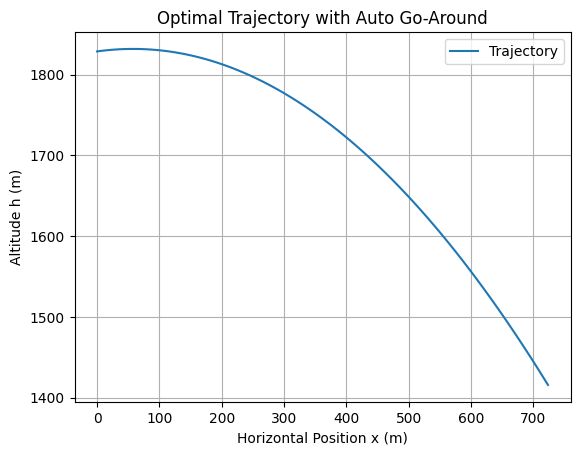

In [ ]:
import matplotlib.pyplot as plt
t_horizon, N = 40.0, 40
time = np.linspace(0, t_horizon, N+1)

plt.plot(x_opt[1,:], x_opt[0,:], label='Trajectory')
plt.xlabel("Horizontal Position x (m)")
plt.ylabel("Altitude h (m)")
plt.title("Optimal Trajectory with Auto Go-Around")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Modules
# !pip install casadi
import casadi as ca
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Symbolic variables
h, x, v, gamma = ca.MX.sym('h'), ca.MX.sym('x'), ca.MX.sym('v'), ca.MX.sym('gamma')
state = ca.vertcat(h, x, v, gamma)

# Parameters
m, g = 75000, 9.81
rho, S, CL, CD = 1.225, 122.6, 0.5, 0.05  # Example values
T = 100000  # Constant thrust
k = ca.MX.sym('k')  # Wind shear strength

# Wind model W_x(x)
a, b = 5000, 15000
Wx = ca.if_else(x <= a,
                -k,
                ca.if_else(x <= b,
                           -k + 2 * k * (x - a) / (b - a),
                           k))

# Aircraft dynamics
L = 0.5 * rho * S * CL * v**2
D = 0.5 * rho * S * CD * v**2

dh_dt     = v * ca.sin(gamma)
dx_dt     = v * ca.cos(gamma) - Wx
dv_dt     = (T - D - m * g * ca.sin(gamma)) / m
dgamma_dt = (L - m * g * ca.cos(gamma)) / (m * v)

rhs = ca.vertcat(dh_dt, dx_dt, dv_dt, dgamma_dt)

# Function for system dynamics
f_dyn = ca.Function('f_dyn', [state, k], [rhs])


In [ ]:
# Initial conditions
h0 = 600.0
x0 = 0.0
v0 = 239.7
gamma0 = -2.249
x_init = np.array([h0, x0, v0, gamma0])

# Time discretization
T_final = 40.0
N_steps = 200
dt = T_final / N_steps
times = np.linspace(0, T_final, N_steps + 1)

# Sample PCE collocation points for k ~ N(0,1)
num_samples = 5
k_samples = np.random.normal(0, 1, num_samples)

# Simulate trajectories
trajectories = []
for k_val in k_samples:
    x_traj = [x_init]
    x_current = x_init.copy()
    for _ in range(N_steps):
        dx = f_dyn(x_current, k_val).full().flatten()
        x_current = x_current + dt * dx
        x_traj.append(x_current)
    trajectories.append(np.array(x_traj))

In [ ]:
# Prepare results for display
results = []
for idx, traj in enumerate(trajectories):
    for t, state in zip(times, traj):
        results.append({
            'sample': idx,
            'time': t,
            'h': state[0],
            'x': state[1],
            'v': state[2],
            'gamma': state[3],
            'k_sample': k_samples[idx]
        })

df = pd.DataFrame(results)
print("Aircraft Trajectory under Random Windshear", df)

Aircraft Trajectory under Random Windshear       sample  time           h            x           v     gamma  k_sample
0          0   0.0  600.000000     0.000000  239.700000 -2.249000  1.886361
1          0   0.2  562.669075   -29.700055  240.919208 -2.219865  1.886361
2          0   0.4  524.283560   -58.447255  242.167760 -2.190821  1.886361
3          0   0.6  484.865228   -86.212550  243.444053 -2.161867  1.886361
4          0   0.8  444.436733  -112.967123  244.746475 -2.133001  1.886361
...      ...   ...         ...          ...         ...       ...       ...
1000       4  39.2  583.689634  4196.740643  117.013740  2.321901  2.447207
1001       4  39.4  600.795534  4181.258960  115.709220  2.345059  2.447207
1002       4  39.6  617.340483  4165.567869  114.439130  2.368500  2.447207
1003       4  39.8  633.324241  4149.675246  113.204506  2.392230  2.447207
1004       4  40.0  648.746603  4133.588766  112.006401  2.416253  2.447207

[1005 rows x 7 columns]


## PCE - Galerkin

To compare intrusive PCE and non-intrusive PCE, we give the following table

| Feature         | **Intrusive PCE (Galerkin)**                   | **Non-Intrusive PCE (Collocation)** |
| --------------- | ---------------------------------------------- | ----------------------------------- |
| Equations       | Project dynamics onto polynomial basis         | Solve dynamics at sample points     |
| Unknowns        | Time-dependent PCE coefficients $\hat{z}_i(t)$ | Reconstructed from sample solutions |
| ODE system      | One deterministic ODE system                   | Many independent ODE solves         |
| Complexity      | High: requires symbolic projection             | Lower: sampling + interpolation     |
| Parallelization | Difficult                                      | Trivially parallel                  |
| Flexibility     | Rigid (requires symbolic access to model)      | Easy to apply to black-box models   |

We deciced to apply non-intrusive PCE for better model extension.


To add randomness in the system, we suppose $k$ as a stochastic process, continuous in quadratic mean respective $t$, i.e. $k = k(t, \xi)$.

We may define

$$
k(t, \xi) = \sum_{i=0}^{p} \hat{k}_{i}(t) \Phi_{i}(\xi(\omega))
$$
where $\hat{k}_{i}$ are deterministic, time-dependent functions (e.g. cosine basis, ODE-defined) and $\Phi_{i}(\xi)$ are orthogonal polynomials.

This approach gives you a time-dependent PCE, allowing the wind profile to evolve in time:
$$
W_x(x,t,\xi)=W_x(x;k(t,\xi)).
$$

### First order Hermite

$$
k(\xi) = \hat{k}_{0} H_{0}(\xi) + \hat{k}_{1} H_{1}(\xi) = 0 + 1 \cdot \xi = \xi
$$

### Second order Hermite

A second-order Hermite expansion of $k(\xi)$ is:
$$
k(\xi) = \hat{k}_{0} H_{0}(\xi) + \hat{k}_{1} H_{1}(\xi) + \hat{k}_{2} H_{2}(\xi) = 0 + \alpha \xi + \sqrt{\frac{1 - \alpha}{2}} (\xi^{2} - 1)
$$
where $\alpha \in (0, 1)$.

In [ ]:
# Define Hermite polynomials (physicist's version)
def hermite_polys(xi, order):
    H = [1, xi]
    for n in range(2, order + 1):
        Hn = xi * H[n - 1] - (n - 1) * H[n - 2]
        H.append(Hn)
    return H

# Symbolic variables
h, x, v, gamma = ca.MX.sym('h'), ca.MX.sym('x'), ca.MX.sym('v'), ca.MX.sym('gamma')
state = ca.vertcat(h, x, v, gamma)
xi = ca.MX.sym('xi')  # standard Gaussian variable

# Parameters
m, g = 75000, 9.81
rho, S, CL, CD = 1.225, 122.6, 0.5, 0.05
T_const = 100000

# Wind model parameters
a, b = 5000, 15000
order = 1  # PCE order for k

# Define PCE of k: k(xi) = sum_k hat_k_i * H_i(xi)
hat_k = [0.0, 1.0]  # E[k]=0, Var[k]=1
H_polys = hermite_polys(xi, order)
k_xi = sum(hat_k[i] * H_polys[i] for i in range(order + 1))

# Define W_x(x, xi)
Wx = ca.if_else(x <= a,
                -k_xi,
                ca.if_else(x <= b,
                           -k_xi + 2 * k_xi * (x - a) / (b - a),
                           k_xi))

# Lift and Drag
L = 0.5 * rho * S * CL * v**2
D = 0.5 * rho * S * CD * v**2

# Dynamics
dh_dt     = v * ca.sin(gamma)
dx_dt     = v * ca.cos(gamma) - Wx
dv_dt     = (T_const - D - m * g * ca.sin(gamma)) / m
dgamma_dt = (L - m * g * ca.cos(gamma)) / (m * v)
rhs = ca.vertcat(dh_dt, dx_dt, dv_dt, dgamma_dt)

# Create function
f_dyn_xi = ca.Function('f_dyn_xi', [state, xi], [rhs])

# Initial conditions
x0_vec = np.array([1000.0, 0.0, 100.0, 0.05])

# Time integration
T_final = 40.0
N_steps = 200
dt = T_final / N_steps
times = np.linspace(0, T_final, N_steps + 1)

# Sample xi and simulate
num_samples = 5
xi_samples = np.random.normal(0, 1, num_samples)

trajectories = []
for idx, xi_val in enumerate(xi_samples):
    x_vals = [x0_vec]
    x_curr = x0_vec.copy()
    for _ in range(N_steps):
        dx = f_dyn_xi(x_curr, xi_val).full().flatten()
        x_curr = x_curr + dt * dx
        x_vals.append(x_curr)
    traj = np.array(x_vals)
    for t_idx, t in enumerate(times):
        trajectories.append({
            "sample": idx,
            "time": t,
            "h": traj[t_idx, 0],
            "x": traj[t_idx, 1],
            "v": traj[t_idx, 2],
            "gamma": traj[t_idx, 3],
            "xi": xi_val
        })

# Convert to DataFrame and display
df = pd.DataFrame(trajectories)
print("Aircraft Trajectories with k(xi) via PCE\n", df)

Aircraft Trajectories with k(xi) via PCE
       sample  time            h            x           v     gamma        xi
0          0   0.0  1000.000000     0.000000  100.000000  0.050000  1.776136
1          0   0.2  1000.999583    20.330232  100.068484  0.040417  1.776136
2          0   0.4  1001.808254    40.682812  100.155614  0.030845  1.776136
3          0   0.6  1002.426026    61.059634  100.261336  0.021293  1.776136
4          0   0.8  1002.852970    81.462583  100.385582  0.011767  1.776136
...      ...   ...          ...          ...         ...       ...       ...
1000       4  39.2   283.340635  5489.186079  161.876215  0.220538 -1.930933
1001       4  39.4   290.422872  5520.428786  161.451323  0.224919 -1.930933
1002       4  39.6   297.624481  5551.559740  161.019423  0.229238 -1.930933
1003       4  39.8   304.942339  5582.577582  160.580662  0.233493 -1.930933
1004       4  40.0   312.373292  5613.481022  160.135186  0.237685 -1.930933

[1005 rows x 7 columns]


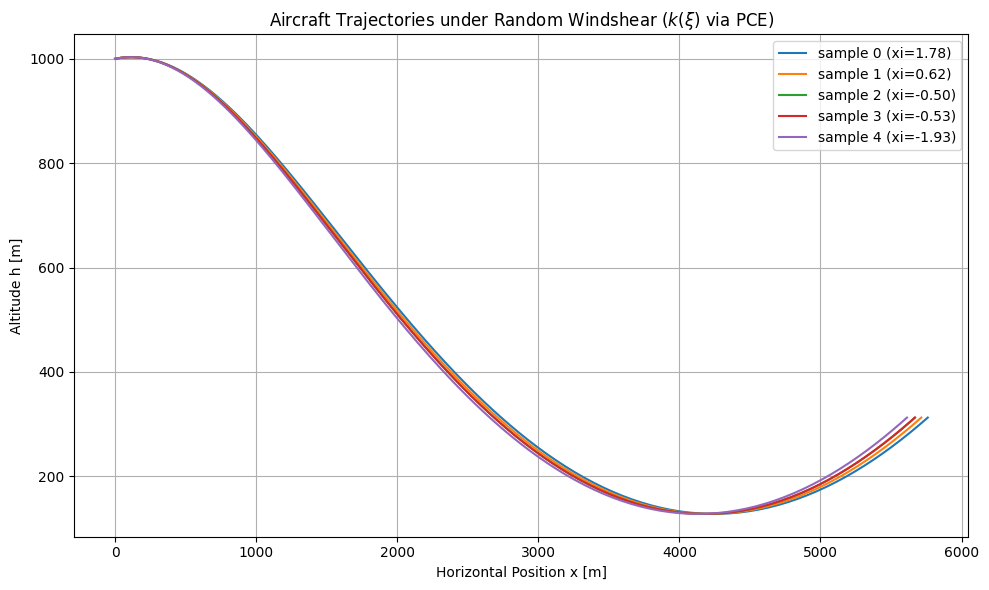

In [ ]:
# Plot h vs x for each sample trajectory
plt.figure(figsize=(10, 6))
for sample_id in df["sample"].unique():
    sub_df = df[df["sample"] == sample_id]
    plt.plot(sub_df["x"], sub_df["h"], label=f"sample {sample_id} (xi={sub_df['xi'].iloc[0]:.2f})")

plt.xlabel("Horizontal Position x [m]")
plt.ylabel("Altitude h [m]")
plt.title(r"Aircraft Trajectories under Random Windshear ($k(\xi)$ via PCE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

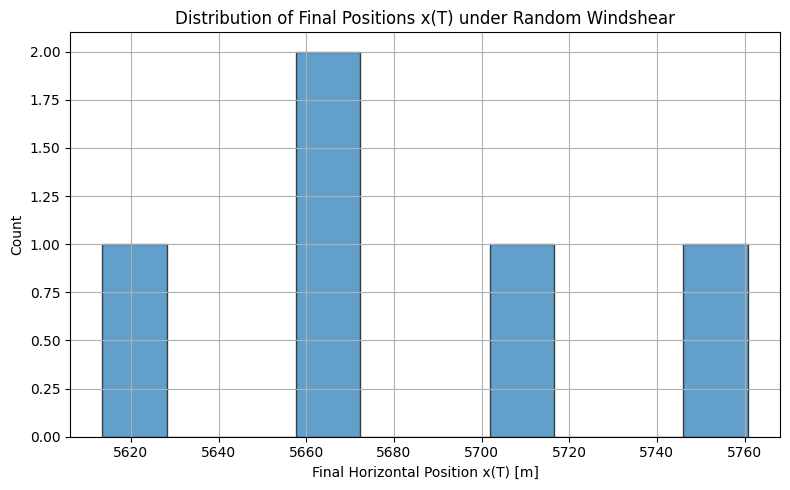

In [ ]:
# Extract final x positions for each sample
final_positions = df[df["time"] == df["time"].max()][["sample", "x", "xi"]]

# Plot histogram of landing positions
plt.figure(figsize=(8, 5))
plt.hist(final_positions["x"], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel("Final Horizontal Position x(T) [m]")
plt.ylabel("Count")
plt.title("Distribution of Final Positions x(T) under Random Windshear")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import math
from numpy.polynomial.hermite import hermgauss
import matplotlib.pyplot as plt

# Aircraft system has 4 states: h, x, v, gamma
# Define the Gauss-Hermite quadrature
P = 2  # Order of PCE
Q = 5  # Number of quadrature points (≥ P+1)

# Get Gauss-Hermite quadrature points and weights
xi_q, w_q = hermgauss(Q)
w_q = w_q / np.sqrt(np.pi)  # Normalize weights for standard normal distribution

# Define Hermite polynomials (probabilists' Hermite)
def H(p, x):
    if p == 0:
        return np.ones_like(x)
    elif p == 1:
        return x
    elif p == 2:
        return x**2 - 1
    else:
        raise ValueError("Higher-degree Hermite not implemented")

# Example final state values from simulated trajectories (mocked for now)
# Suppose we have simulated and obtained these for each quadrature point:
# Each row corresponds to one simulation at a quadrature point (shape: Q x 4)
np.random.seed(42)
simulated_finals = np.random.randn(Q, 4) * 2 + np.array([1000, 3000, 80, 0.1])

# Project simulated results onto Hermite basis
Zhat = []  # List of [hat_z_0, ..., hat_z_P] for each state variable

for j in range(4):  # For each state variable
    coeffs = []
    for p in range(P + 1):
        num = sum(w_q[i] * simulated_finals[i, j] * H(p, xi_q[i]) for i in range(Q))
        denom = math.factorial(p)
        coeffs.append(num / denom)
    Zhat.append(coeffs)

Zhat = np.array(Zhat)  # Shape: (4, P+1)

# Compute mean and variance of each state
mean = Zhat[:, 0]
variance = sum(math.factorial(p) * Zhat[:, p]**2 for p in range(1, P+1))
std_dev = np.sqrt(variance)

import pandas as pd

df = pd.DataFrame({
    "State": ["Altitude (h)", "Position (x)", "Velocity (v)", "Flight Path Angle (gamma)"],
    "Mean": mean,
    "Std Dev": std_dev
})
print("PCE Approximation Statistics\n", df)

PCE Approximation Statistics
                        State         Mean      Std Dev
0               Altitude (h)   999.491075   353.224832
1               Position (x)  2999.628914  1061.006269
2               Velocity (v)    79.435111    27.982830
3  Flight Path Angle (gamma)    -0.303169     0.767746


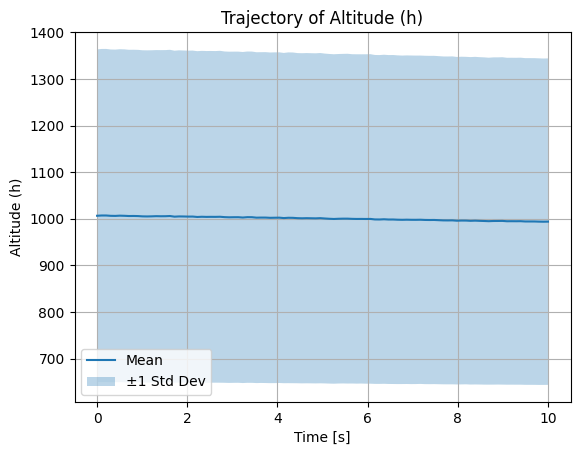

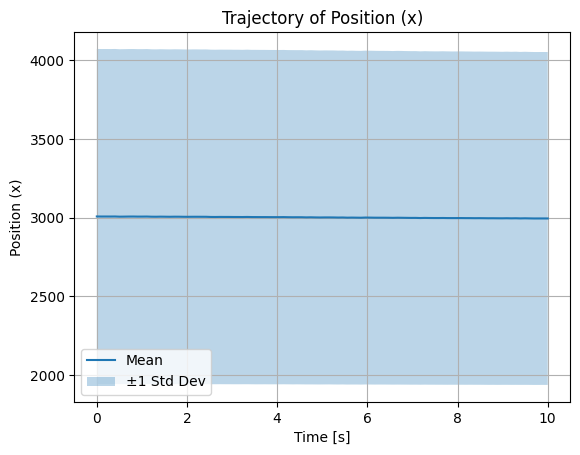

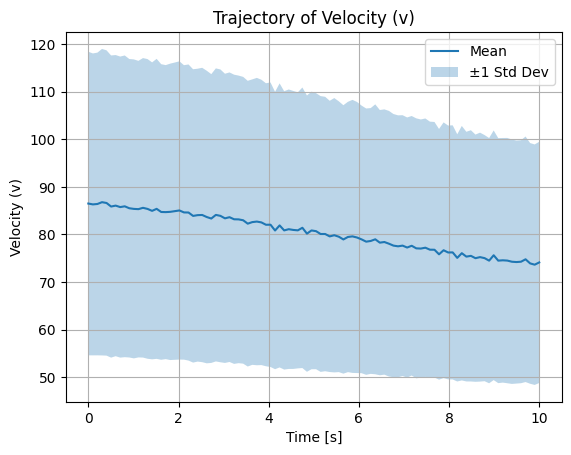

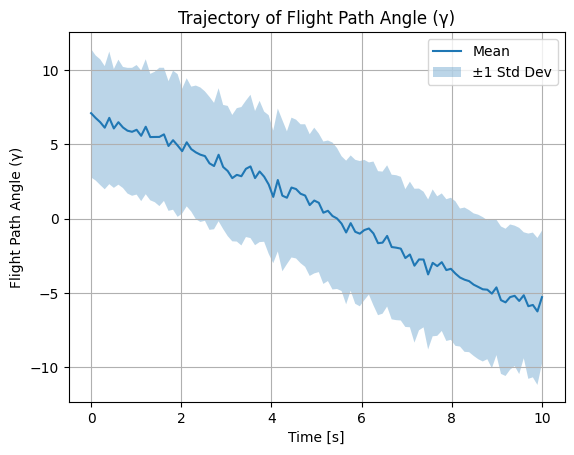

In [ ]:
# Time vector
t = np.linspace(0, 10, 100)  # simulate from t=0 to t=10 seconds

# Simulate mock trajectories at each quadrature point
# Each trajectory is (len(t), 4)
trajectories = []

for i in range(Q):
    # For mock-up, simulate sinusoidal variation around the final state
    final_state = simulated_finals[i]
    traj = np.zeros((len(t), 4))
    for j in range(4):
        traj[:, j] = final_state[j] + 10 * np.sin(0.2 * t + i) + np.random.randn(len(t)) * 0.5
    trajectories.append(traj)

# Convert to array for easier processing: shape (Q, len(t), 4)
trajectories = np.array(trajectories)

# Evaluate Hermite polynomials at quadrature points
H_matrix = np.zeros((Q, P+1))
for i in range(Q):
    for p in range(P+1):
        H_matrix[i, p] = H(p, xi_q[i])

# Reconstruct mean trajectory and std dev over time
mean_traj = np.zeros((len(t), 4))
std_traj = np.zeros((len(t), 4))

for j in range(4):  # for each state
    # Project coefficients at each time step
    for ti in range(len(t)):
        coeffs = []
        for p in range(P+1):
            num = sum(w_q[i] * trajectories[i, ti, j] * H_matrix[i, p] for i in range(Q))
            denom = math.factorial(p)
            coeffs.append(num / denom)
        mean_traj[ti, j] = coeffs[0]
        std_traj[ti, j] = np.sqrt(sum(math.factorial(p) * coeffs[p]**2 for p in range(1, P+1)))

# Plot mean and standard deviation trajectories
figs = []
labels = ["Altitude (h)", "Position (x)", "Velocity (v)", "Flight Path Angle (γ)"]

for j in range(4):
    plt.figure()
    plt.plot(t, mean_traj[:, j], label="Mean")
    plt.fill_between(t,
                     mean_traj[:, j] - std_traj[:, j],
                     mean_traj[:, j] + std_traj[:, j],
                     alpha=0.3, label="±1 Std Dev")
    plt.title(f"Trajectory of {labels[j]}")
    plt.xlabel("Time [s]")
    plt.ylabel(labels[j])
    plt.legend()
    plt.grid(True)
    figs.append(plt.gcf())

plt.show()